In [137]:
import torch
import matplotlib.pylab as plt
from jumping_env.env import VanillaEnv
from typing import List
from torchvision.utils import make_grid
from rl.common.buffer2 import Transition, Episode
import numpy as np

In [138]:
def compare_imgs(a,b,title:str = ""):
   f, axarr = plt.subplots(1,2)
   axarr[0].imshow(np.flipud(a.squeeze()), cmap='gray', vmin=0., vmax=1.)
   axarr[1].imshow(np.flipud(b.squeeze()), cmap='gray', vmin=0., vmax=1.)
   if len(title) > 0: plt.title(title)
   plt.show()

In [139]:
def generate_expert_trajectories(env, n_episodes):
    gamma = 0.99

    episodes: List[Episode] = []

    for i in range(n_episodes):
        done = False
        episode = Episode(discount=gamma)
        obs = env.reset()
        obstacle_position = env.actualEnv.obstacle_position
        jumping_pixel = obstacle_position - 14
        step = 0
        while not done:
            action = 1 if step == jumping_pixel else 0
            next_obs, reward, done, _ = env.step(action)
            episode.append(Transition(obs, action, reward, 0))
            obs = next_obs
            env.render()
            step += 1

        episodes.append(episode)
    return episodes

X = generate_expert_trajectories(VanillaEnv(configurations=[(38, 8)]), n_episodes=1)[0]
Y = generate_expert_trajectories(VanillaEnv(configurations=[(22, 32)]), n_episodes=1)[0]
X_action = X.actions()
Y_action = Y.actions()

In [146]:
def psm(x, y, gamma=0.99):
    """
    Calculates the psm for the enire sequence (starting at the first element)
    """
    x1 = x if len(x) == 1 else x[1:]
    y1 = y if len(y) == 1 else y[1:]
    tv = 0. if x[0] == y[0] else 1.
    if(len(x1) == len(y1) == 1):
        return tv
    else:
        return tv + gamma * psm(x1, y1, gamma)

print(psm([0,0,0,1,0], [0,1,0,0,0]))
print(psm([0,0,0,1,0], [1,0,0,0]))
print(psm([0,0,0,1,0], [0,0,0]))
print(psm([0,0,0,1,0], [0,0]))
print(psm([0,0,0,1,0], [0]))


1.960299
1.9702989999999998
0.9702989999999999
0.9702989999999999
0.9702989999999999


[0.92274469 0.93206535 0.94148015 0.95099005 0.96059601 0.970299
 0.9801     0.99       1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]


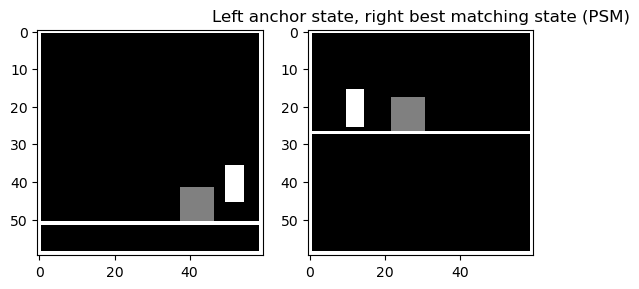

In [145]:
compare_idx = 50
# Given the state at index compare_idx, which state in Y is most similar?

psm_y = np.zeros(len(Y_action)-2)
for i in range(len(Y_action)-2):
    psm_y[i] = psm(X_action[compare_idx:], Y_action[i:])

matching_idx = np.argmin(psm_y)
print(psm_y)
compare_imgs(X.transitions[compare_idx].state, Y.transitions[matching_idx+1].state, "Left anchor state, right best matching state (PSM)")
